# TRUSWorthy - Results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import brier_score_loss, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

## Make Test and Val. DataFrames

In [10]:
#seeds = [5, 81, 126, 602, 42, 881, 659, 321, 292]
#seeds = [881, 602, 126, 292, 42]
import os; seeds=os.listdir('trusworthy')
print(seeds)
FOLDS = 5
df_test = pd.DataFrame()
df_val = pd.DataFrame()
for seed in seeds:
    for fold in range(FOLDS):
        dft_t = pd.read_csv(f'trusworthy/{seed}/fold{fold}/test.csv') 
        dft_t['fold'] = dft_t.y.apply(lambda x: fold)
        dft_t['seed'] = dft_t.y.apply(lambda x: seed)
        
        dft_v = pd.read_csv(f'trusworthy/{seed}/fold{fold}/val.csv')
        dft_v['fold'] = dft_v.y.apply(lambda x: fold)
        dft_v['seed'] = dft_v.y.apply(lambda x: seed)

        df_test = df_test.append(dft_t, ignore_index=True)
        df_val = df_val.append(dft_v, ignore_index=True)

['881', '292', '602', '659', '42', '81', '126', '321', '5', '512']


In [11]:
df_test['patient'] = df_test.core_specifier.apply(lambda x: x.split('_')[0])
df_val['patient'] = df_val.core_specifier.apply(lambda x: x.split('_')[0])

## Calculate Test Metrics Per Fold

In [12]:
# metrics for each fold for each seed
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, brier_score_loss

for seed in seeds:
    aucs = []
    baccs = []
    senss = []
    specs = []
    for fold in range(FOLDS):
        dfc = df_test[df_test.seed == seed]
        dfc = dfc[dfc.fold == fold]
        aucs.append(roc_auc_score(dfc.y, dfc.prob_1))
        senss.append(recall_score(dfc.y, dfc.prob_1.round()))
        specs.append(recall_score(dfc.y, dfc.prob_1.round(), pos_label=0))
        baccs.append(balanced_accuracy_score(dfc.y, dfc.prob_1.round()))

    avgauc = 100*round(np.mean(aucs), 3)
    stdauc = 100*round(np.std(aucs), 3)
    avgbac = 100*round(np.mean(baccs), 3)
    stdbac = 100*round(np.std(baccs), 3)
    avgsens = 100*round(np.mean(senss), 3)
    stdsens = 100*round(np.std(senss), 3)
    avgspec = 100*round(np.mean(specs), 3)
    stdspec = 100*round(np.std(specs), 3)

    print(f'seed={seed} AUC:{avgauc}+-{stdauc} BAC:{avgbac}+-{stdbac} Sens:{avgsens}+-{stdsens} Spec:{avgspec}+-{stdspec}')


seed=881 AUC:76.4+-2.0 BAC:68.30000000000001+-3.1 Sens:59.699999999999996+-14.2 Spec:77.0+-9.700000000000001
seed=292 AUC:76.2+-2.1999999999999997 BAC:68.5+-1.5 Sens:71.8+-8.200000000000001 Spec:65.3+-11.0
seed=602 AUC:77.4+-2.1 BAC:69.5+-3.5999999999999996 Sens:67.0+-18.9 Spec:72.0+-12.5
seed=659 AUC:76.6+-1.2 BAC:64.9+-3.3000000000000003 Sens:60.6+-24.7 Spec:69.19999999999999+-24.3
seed=42 AUC:76.1+-3.5000000000000004 BAC:67.5+-5.6000000000000005 Sens:64.2+-25.1 Spec:70.8+-16.5
seed=81 AUC:76.0+-1.3 BAC:68.5+-2.1 Sens:68.7+-12.6 Spec:68.30000000000001+-14.299999999999999
seed=126 AUC:77.3+-1.7999999999999998 BAC:67.2+-4.7 Sens:64.60000000000001+-23.0 Spec:69.69999999999999+-18.6
seed=321 AUC:75.4+-2.3 BAC:66.0+-3.9 Sens:65.10000000000001+-24.6 Spec:66.9+-19.8
seed=5 AUC:76.1+-1.5 BAC:67.0+-3.9 Sens:67.10000000000001+-21.0 Spec:66.9+-19.3
seed=512 AUC:76.0+-3.5999999999999996 BAC:64.9+-4.2 Sens:80.30000000000001+-12.5 Spec:49.5+-18.6


## Ensembling

In [13]:
df_test_ens = pd.DataFrame()
df_test_ens['y'] = df_test.loc[df_test.seed == seeds[0]].y.values
df_val_ens = pd.DataFrame()
df_val_ens['y'] = df_val.loc[df_val.seed == seeds[0]].y.values

for seed in seeds:
    df_test_ens[f'scores_{seed}'] = df_test.loc[df_test.seed == seed].prob_1.values
    df_val_ens[f'scores_{seed}'] = df_val.loc[df_val.seed == seed].prob_1.values

In [15]:
df_test_ens['avg_prob_1'] = df_test_ens[['scores_'+str(seed) for seed in seeds]].mean(axis=1)
df_val_ens['avg_prob_1'] = df_val_ens[['scores_'+str(seed) for seed in seeds]].mean(axis=1)

In [16]:
df_test_ens.head()

,y,scores_881,scores_292,scores_602,scores_659,scores_42,scores_81,scores_126,scores_321,scores_5,scores_512,avg_prob_1
0,0,0.007677,0.003914,0.985640,0.283475,0.577574,0.526052,0.493447,0.453119,0.421314,0.311462,0.406368
1,0,0.998409,0.995513,0.905796,0.790973,0.925002,0.807181,0.763063,0.396683,0.816886,0.666313,0.806582
2,0,0.001023,0.001376,0.282131,0.326455,0.346587,0.383286,0.040913,0.254893,0.364473,0.176197,0.217733
3,0,0.842697,0.945319,0.609185,0.434568,0.483600,0.694719,0.551533,0.333807,0.428797,0.454670,0.577890
4,0,0.002820,0.002208,0.010475,0.321328,0.339357,0.495015,0.098335,0.323215,0.423033,0.514959,0.253075


In [17]:
df_test_ens.to_csv("trusworthy_df_test_ens.csv")

In [18]:
df_test_ens['variance'] = df_test_ens[[f'scores_{seed}' for seed in seeds]].var(axis=1)
df_test_ens['uncertainty_binned'] = (df_test_ens['variance'] - df_test_ens['variance'].min()) / (df_test_ens['variance'].max() - df_test_ens['variance'].min())

In [24]:
df_test_ens['uncertainty_msp'] = df_test_ens.avg_prob_1.apply(lambda x: max(x, 1-x))

In [25]:
df_test.patient.nunique()

629

In [33]:
def compute_ensemble_metrics(use_uncertainty=False, threshold=0.5):
    aucs = []
    baccs = []
    sens = []
    specs = []
    eces = []
    briers = []
    nlls = []
    f1s = []
    num_patients = []
    num_cores = []
    for fold in range(FOLDS):
        dfc = df_test[df_test.fold == fold]

        preds_by_seed = {}
        for seed in seeds:
            preds_by_seed[seed] = dfc[dfc.seed == seed].prob_1.values

        
        ens = pd.DataFrame()
        ens['y'] = dfc[dfc.seed == seed].y.values
        ens['patient'] = dfc[dfc.seed == seed].patient.values
        for seed in seeds:
            ens[f'model_{seed}'] = preds_by_seed[seed]
        ens['variance'] = ens[[f'model_{seed}' for seed in seeds]].var(axis=1)
        ens['uncertainty'] = (ens.variance - df_test_ens['variance'].min()) / (ens.variance.max() - ens.variance.min())
        ens['avg_prob_1'] = ens[[f'model_{seed}' for seed in seeds]].mean(axis=1)

        dfc_val = df_val[df_val.fold == fold]
        ens_val = pd.DataFrame()
        ens_val['y'] = dfc_val[dfc_val.seed == seed].y.values
        for seed in seeds:
            ens_val[f'model_{seed}'] = dfc_val[dfc_val.seed == seed].prob_1.values
        ens_val['variance'] = ens_val[[f'model_{seed}' for seed in seeds]].var(axis=1)
        ens_val['uncertainty'] = ens_val.variance / (ens_val.variance.max() - ens_val.variance.min())
        ens_val['avg_prob_1'] = ens_val[[f'model_{seed}' for seed in seeds]].mean(axis=1)

        if use_uncertainty:
            q = 1 - threshold
            df_keep = df_test_ens[df_test_ens.uncertainty_msp <= np.quantile(df_test_ens.uncertainty_msp, q)]
            baccs.append(balanced_accuracy_score(df_keep.y, df_keep.avg_prob_1.round()))
        else:
            baccs.append(balanced_accuracy_score(ens.y, ens.avg_prob_1.round()))

        # Calculate AUC
        try:
            aucs.append(roc_auc_score(ens.y, ens.avg_prob_1))
        except:
            aucs.append(0)
            print('AUC error')

        # Calculate Balanced Accuracy
        

        # Calculate Sensitivity
        sens.append(recall_score(ens.y, ens.avg_prob_1.round()))

        # Calculate Specificity
        specs.append(recall_score(ens.y, ens.avg_prob_1.round(), pos_label=0))

        # Calculate F1
        f1s.append(f1_score(ens.y, ens.avg_prob_1.round()))

        # Number of patients
        num_patients.append(ens.patient.nunique())

        # Number of cores
        num_cores.append(ens.shape[0])

    # print AUC +- std # BACC +- std Sen +- std Spec +- std

    if not use_uncertainty:
        print('AUROC:', 100*round(np.mean(aucs), 3), '+-', 100*round(np.std(aucs), 3))
        print('B.Acc:', 100*round(np.mean(baccs),3), '+-', 100*round(np.std(baccs),3))
        print('Sens.:', 100*round(np.mean(sens),3), '+-', 100*round(np.std(sens),3))
        print('Spec.:', 100*round(np.mean(specs),3), '+-', 100*round(np.std(specs),3))

    return round(np.mean(aucs), 3), round(np.mean(baccs),3), sum(num_patients), sum(num_cores)
    

In [34]:
compute_ensemble_metrics(use_uncertainty=False)

AUROC: 79.9 +- 1.4000000000000001
B.Acc: 71.5 +- 0.7000000000000001
Sens.: 71.6 +- 8.0
Spec.: 71.3 +- 6.800000000000001


(0.799, 0.715, 629, 5060)

In [35]:
df_test_ens['uncertainty_msp'] = df_test_ens.apply(lambda x: 1 - max(x.avg_prob_1, 1-x.avg_prob_1), axis=1)

In [36]:
seed_preds = {}
for seed in seeds:
    seed_preds[seed] = df_test[df_test.seed == seed].prob_1.values

df2cp = pd.DataFrame()
for seed in seeds:
    df2cp[f'model_{seed}'] = seed_preds[seed]
df2cp['fold'] = df_test[df_test.seed == seed].fold.values
df2cp['y'] = df_test[df_test.seed == seed].y.values
df2cp['patient'] = df_test[df_test.seed == seed].patient.values
df2cp['avg_prob_1'] = df2cp[[f'model_{seed}' for seed in seeds]].mean(axis=1)
df2cp['variance'] = df2cp[[f'model_{seed}' for seed in seeds]].var(axis=1)
df2cp['uncertainty_msp'] = df2cp.apply(lambda x: 1 - max(x.avg_prob_1, 1-x.avg_prob_1), axis=1)


_tmp_stds = []
for q in np.arange(0.1, 1.1, 0.1):
    df_keep = df2cp[df2cp.uncertainty_msp <= np.quantile(df_test_ens.uncertainty_msp, q)]
    accs = []
    aucs = []
    sens = []
    spec = []
    patients = []
    for fold in range(FOLDS):
        df3cp = df_keep[df_keep.fold == fold]
        accs.append(balanced_accuracy_score(df3cp.y, df3cp.avg_prob_1.round()))
        sens.append(recall_score(df3cp.y, df3cp.avg_prob_1.round()))
        spec.append(recall_score(df3cp.y, df3cp.avg_prob_1.round(), pos_label=0))
        try:
            aucs.append(roc_auc_score(df3cp.y, df3cp.avg_prob_1))
        except:
            pass
        patients.append(df3cp.patient.nunique())
    _tmp_stds.append(np.std(accs))
    print('Threshold:', 1-q)
    print(f'\tPatients: {sum(patients)} AUROC: {100*round(np.mean(aucs), 3)} Sens: {100*round(np.mean(sens), 3)} Spec: {100*round(np.mean(spec), 3)} B.Acc: {100*round(np.mean(accs),3)} ')

print()
print(_tmp_stds)

/Users/harma/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.9
	Patients: 208 AUROC: 87.5 Sens: 65.3 Spec: 98.2 B.Acc: 91.7 
Threshold: 0.8
	Patients: 341 AUROC: 90.5 Sens: 88.8 Spec: 93.30000000000001 B.Acc: 91.0 
Threshold: 0.7
	Patients: 461 AUROC: 90.7 Sens: 86.8 Spec: 88.8 B.Acc: 87.8 
Threshold: 0.6
	Patients: 526 AUROC: 88.5 Sens: 83.39999999999999 Spec: 86.2 B.Acc: 84.8 
Threshold: 0.5
	Patients: 574 AUROC: 86.8 Sens: 81.89999999999999 Spec: 82.69999999999999 B.Acc: 82.3 
Threshold: 0.4
	Patients: 597 AUROC: 85.5 Sens: 77.7 Spec: 80.2 B.Acc: 78.9 
Threshold: 0.29999999999999993
	Patients: 609 AUROC: 83.8 Sens: 77.5 Spec: 77.9 B.Acc: 77.7 
Threshold: 0.19999999999999996
	Patients: 618 AUROC: 82.39999999999999 Sens: 76.1 Spec: 75.2 B.Acc: 75.6 
Threshold: 0.09999999999999998
	Patients: 623 AUROC: 81.2 Sens: 74.3 Spec: 73.1 B.Acc: 73.7 
Threshold: 0.0
	Patients: 629 AUROC: 79.9 Sens: 71.6 Spec: 71.3 B.Acc: 71.5 

[0.12240151258252109, 0.08006286131052082, 0.050108977000517446, 0.039304707888246075, 0.03036672779604978, 0.027462

In [ ]:
[0.701, 0.716, 0.738, 0.757, 0.77, 0.787, 0.798, 0.797, 0.812, 0.861]

In [ ]:
[71.5, 73.7, 75.6, 77.7, 78.9, 82.3, 84.8, 87.8, 91, 91.7]

In [ ]:
_tmp_b_accs = []
for q in np.arange(0.1, 1.1, 0.1):
    print(q, np.quantile(df_test_ens.uncertainty_msp, q))
    df_keep = df_test_ens[df_test_ens.uncertainty_msp <= np.quantile(df_test_ens.uncertainty_msp, q)]
    _tmp_b_accs.append(balanced_accuracy_score(df_keep.y, df_keep.avg_prob_1.round()))

plt.plot(1 - np.arange(0.1, 1.1, 0.1), _tmp_b_accs, label='Balanced accuracy', marker='^')
print('Balanced accuracy:', _tmp_b_accs)

In [ ]:
df_test[df_test.fold == fold][df_test.seed == 5]

In [ ]:
folds = {
    0: pd.DataFrame(),
    1: pd.DataFrame(),
    2: pd.DataFrame(),
    3: pd.DataFrame(),
    4: pd.DataFrame()
}

for fold in range(FOLDS):
    dfc = df_test[df_test.fold == fold]

    for seed in seeds:
        folds[fold][f'model_{seed}'] = dfc[dfc.seed == seed].prob_1.values
    folds[fold]['y'] = dfc[dfc.seed == seed].y.values

    folds[fold]['avg_prob_1'] = folds[fold][[f'model_{seed}' for seed in seeds]].mean(axis=1)

for fold in range(FOLDS):
    auc = roc_auc_score(folds[fold].y, folds[fold].avg_prob_1)
    bacc = balanced_accuracy_score(folds[fold].y, folds[fold].avg_prob_1.round())

    print(f'Fold {fold} AUC: {auc} BACC: {bacc}')

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, recall_score, precision_score, f1_score

aucs = []
balanced_accs = []
remaining_samples = []
remaining_benign_samples = []
remaining_cancer_samples = []
threshes = []
for i in range(1, 11):
    thresh = i/10
    balanced_acc, aucs, df_remain = compute_consensus_metrics(use_uncertainty=True, threshold=thresh)
    balanced_accs.append(balanced_acc)
    threshes.append(thresh)
    remaining_samples.append(df_remain.shape[0])
    remaining_benign_samples.append(df_remain[df_remain.y == 0].shape[0])
    remaining_cancer_samples.append(df_remain[df_remain.y == 1].shape[0])

threshes = threshes[::-1]


0.7084942084942085
0.549853797
0.4632320563628357


<Figure size 432x288 with 0 Axes>

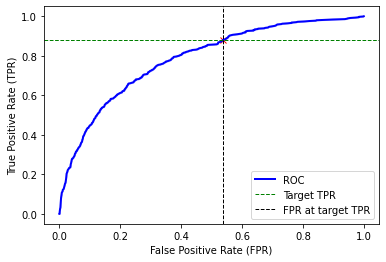

In [38]:
from sklearn.metrics import roc_curve, recall_score

print(recall_score(df_test_ens.y.values.squeeze(), df_test_ens.avg_prob_1.values.squeeze() > 0.5))

fpr, tpr, t = roc_curve(df_test_ens.y.values.squeeze(), df_test_ens.avg_prob_1.values.squeeze())
import matplotlib.pyplot as plt

i = np.abs(t - 0.5).argmin()

target_tpr = 0.88
i = np.abs(tpr - target_tpr).argmin()
fpr_at_target_tpr = fpr[i]

best_threshold = t[np.argmax(tpr - fpr)]
print(best_threshold)

plt.clf()
plt.figure(figsize=(6, 4))

#sns.set_theme(style="whitegrid")

sns.lineplot(x=fpr, y=tpr, label='ROC', color='blue', linewidth=2)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axhline(target_tpr, color='green', linestyle='--', label='Target TPR', linewidth=1)
plt.axvline(fpr_at_target_tpr, color='black', linestyle='--', label='FPR at target TPR', linewidth=1)
plt.scatter(fpr_at_target_tpr, target_tpr, color='red', marker='x', linewidth=1)
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1)
print(1- fpr_at_target_tpr)

plt.savefig('figs/3ab_roc.pdf', bbox_inches='tight')